In [1]:
import numpy as np
import pandas as pd

# import tensorflow as tf

from utils.utils import *
from utils.Atc_code import *
# from utils.utils_baseline_svm import *
from utils.utils_suggest_from_unlabeled import *

# from utils.kwargs_file import kwargs_lin_data_init, kwargs_svm
from utils.kwargs_file import kwargs_lin_data_init

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

%matplotlib inline

# import csv
import os

# from sklearn.feature_extraction import DictVectorizer
# from sklearn import svm

from collections import Counter, OrderedDict
from itertools import product #  combinations

from contextlib import redirect_stdout

# from math import inf
# from time import time

In [2]:
# figure_dir = 'figures/'
figure_dir = '../Automated_categorization_medication_lab/Latex/figures/'

In [3]:
# init data
# labeled data
x, y, n, main_data = init_data()
# labeled data from external sources
x_wiki, y_wiki = init_data_other_atc('wiki_atc_code')
x_drugbank, y_drugbank = init_data_other_atc('drugbank_atc_code')
x_external = x_wiki + x_drugbank
y_external = y_wiki + y_drugbank

# unlabeled data
x_unlabeled = main_data['FREETXT'][n:]

# removing text fields shorter than sliding window width
xy_external = [(xx,yy) for (xx,yy) 
               in zip(x_external, y_external) 
               if len(xx) >= kwargs_lin_data_init.ngram_width]
x_external, y_external = zip(*xy_external)

x_unlabeled = x_unlabeled.loc[[len(k) >= kwargs_lin_data_init.ngram_width 
                               for k in x_unlabeled]]

In [8]:
fig_height = 15
fig_width = 15

x_axis_label_font_size = 28
y_axis_label_font_size = 28

tick_label_font_size = 14

legend_font_size = 16

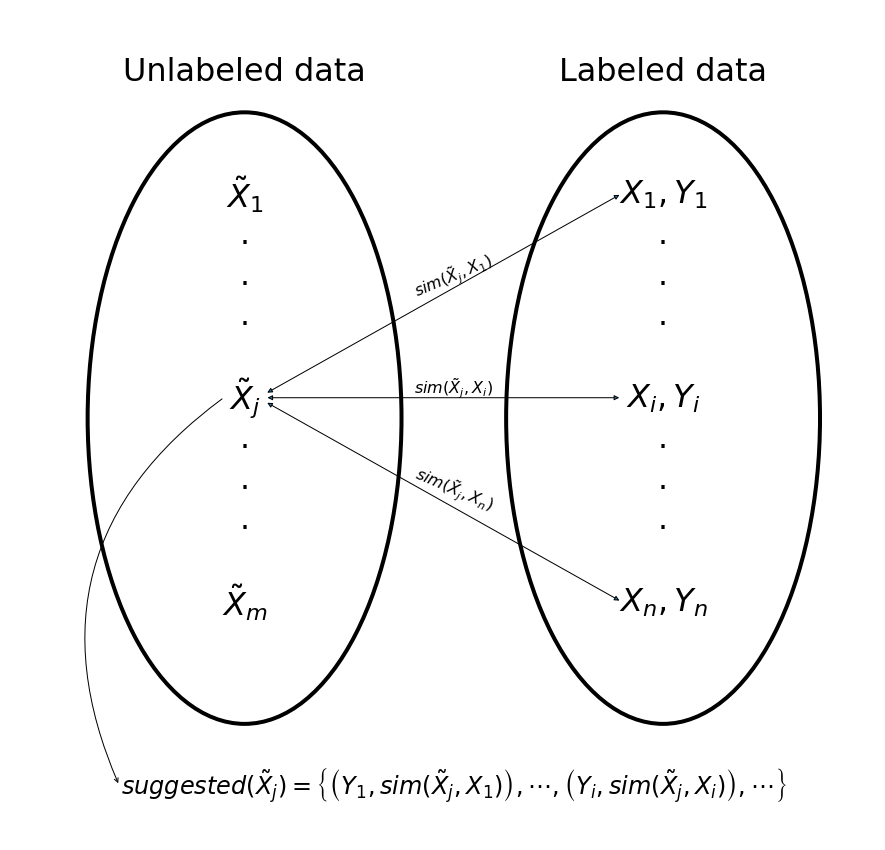

In [5]:
## labeled-unlabeled illustraion
fig = plt.figure(figsize=(fig_width, fig_height))  # width, height

el_height = 30
el_width = 15

el1 = Ellipse((-10, 0), el_width, el_height, 
             facecolor='none',
             edgecolor='black',
             linewidth=4,
             alpha=1)

el2 = Ellipse((10, 0), el_width, el_height, 
             facecolor='none',
             edgecolor='black',
             linewidth=4,
             alpha=1)

ax = fig.add_subplot(111) 

ax.add_artist(el1)
ax.add_artist(el2)
# el1.set_clip_box(ax.bbox)

fontsize_set = 32
fontsize = 32

# plot a dot
plot_dot = lambda x, dist: \
    ax.annotate('.', xy=(x, el_height / 2 - dist),
                ha='center', va='center',
                fontsize=fontsize)

## unlabeled data ellipse
ax.annotate('Unlabeled data', xy=(-10, el_height / 2 + 2),
            ha='center', va='center',
            fontsize=fontsize_set)

## plot x, ..., x, ..., x
ax.annotate(r'$\tilde{X}_1$', xy=(-10, el_height / 2 - 4),
            ha='center', va='center',
            fontsize=fontsize)
# plot 3 dot, horizontally
[plot_dot(-10, _) for _ in [6, 8, 10]]
ax.annotate(r'$\tilde{X}_j$', xy=(-10, el_height / 2 - 14),
            ha='center', va='center',
            fontsize=fontsize)
# plot 3 dot, horizontally
[plot_dot(-10, _) for _ in [16, 18, 20]]
ax.annotate(r'$\tilde{X}_m$', xy=(-10, el_height / 2 - 24),
            ha='center', va='center',
            fontsize=fontsize)


## labeled data ellipse
ax.annotate('Labeled data', xy=(10, el_height / 2 + 2),
            ha='center', va='center',
            fontsize=fontsize_set)

## plot x, ..., x, ..., x
ax.annotate(r'$X_1, Y_1$', xy=(10, el_height / 2 - 4),
            ha='center', va='center',
            fontsize=fontsize)
# plot 3 dot, horizontally
[plot_dot(10, _) for _ in [6, 8, 10]]
ax.annotate(r'$X_i, Y_i$', xy=(10, el_height / 2 - 14),
            ha='center', va='center',
            fontsize=fontsize)
# plot 3 dot, horizontally
[plot_dot(10, _) for _ in [16, 18, 20]]
ax.annotate(r'$X_n, Y_n$', xy=(10, el_height / 2 - 24),
            ha='center', va='center',
            fontsize=fontsize)

# arrows from ~X_j
ax.annotate('',
            xy=(-10 + 1, 0.2 + el_height / 2 - 14),
            xytext=(10 - 2, el_height / 2 - 4),
            arrowprops=dict(arrowstyle='<|-|>'))
ax.annotate('',
            xy=(-10 + 1, 0.0 + el_height / 2 - 14),
            xytext=(10 - 2, el_height / 2 - 14),
            arrowprops=dict(arrowstyle='<|-|>'))
ax.annotate('',
            xy=(-10 + 1, - 0.2 + el_height / 2 - 14),
            xytext=(10 - 2, el_height / 2 - 24),
            arrowprops=dict(arrowstyle='<|-|>'))

## similarity text
ax.annotate(r'$sim(\tilde{X}_j, X_1)$', xy=(0, 7),
            ha='center', va='center',
            fontsize=fontsize*0.5, 
            rotation=23)

ax.annotate(r'$sim(\tilde{X}_j, X_i)$', xy=(0, 1.5),
            ha='center', va='center',
            fontsize=fontsize*0.5)

ax.annotate(r'$sim(\tilde{X}_j, X_n)$', xy=(0, -3.5),
            ha='center', va='center',
            fontsize=fontsize*0.5, 
            rotation=-23)

sim_eq = r'$suggested(\tilde{X}_j) = \left \{ \left( Y_1, sim(\tilde{X}_j, X_1) \right),\cdots ,\left( Y_i, sim(\tilde{X}_j, X_i) \right),\cdots\right \}$'
ax.annotate(sim_eq, xy=(0, -18),
            ha='center', va='center',
            fontsize=fontsize*0.75)

ax.annotate('',
            xy=(-16, -18), xycoords='data',
            xytext=(-10 - 1, el_height / 2 - 14), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=.4"))

ax.set_xlim([-20, 20])
ax.set_ylim([-20, 20])

ax.axis('off')

# plt.show()

plt.savefig(figure_dir + 'unlabeled_labeled_fig.pdf', bbox_inches='tight')

# text and math examples
# https://matplotlib.org/users/text_intro.html
# https://matplotlib.org/users/mathtext.html
# http://matplotlib.org/examples/pylab_examples/tex_unicode_demo.html

# plotting examples
# http://matplotlib.org/examples/pylab_examples/annotation_demo.html
# https://matplotlib.org/users/annotations_guide.html
# http://matplotlib.org/examples/pylab_examples/annotation_demo3.html


In [6]:
"""
Load data from **internal** sources from files, after files have been generated.
Generate some plots to try and understand the label suggestions results.
"""
# load data for figures
sim_dict_filtered = load('resources/sim_dict_filtered_5_8')
# transform the ATC codes into class instances
sim_dict_filtered = \
    {k:[(Atc_code(atc), sim) for atc, sim in v] 
     for k,v in sim_dict_filtered.items()}

label_suggestion_summary = []
for threshold in np.linspace(0.5,1.0, 51):
# for threshold in np.linspace(0.5,1.0, 3):
    _, _, number_of_distinct_labels, \
        labels_sim_tup = \
        get_filtered_suggestion_results(threshold, 
                                        sim_dict_filtered)
    label_suggestion_summary.append(
        record_threshold_data(
            threshold, 
            number_of_distinct_labels, 
            labels_sim_tup, 
            x_unlabeled,
            y, 
            kwargs_lin_data_init)        
        )

In [7]:
label_suggestion_summary =  \
    pd.DataFrame(label_suggestion_summary)
    
# some float formatting
label_suggestion_summary_formatted = \
    label_suggestion_summary.head(5).style.format(
        {'Mean # suggestions': '{:.2f}', 
         'Mean similarity': '{:.2f}', 
         'Min similarity': '{:.2f}', 
         'Unanimous mean similarity': '{:.2f}', 
         'Mean common ATC levels (norm)': '{:.2f}', 
         'Mean common ATC levels, non-unanimous (norm)': '{:.2f}'})

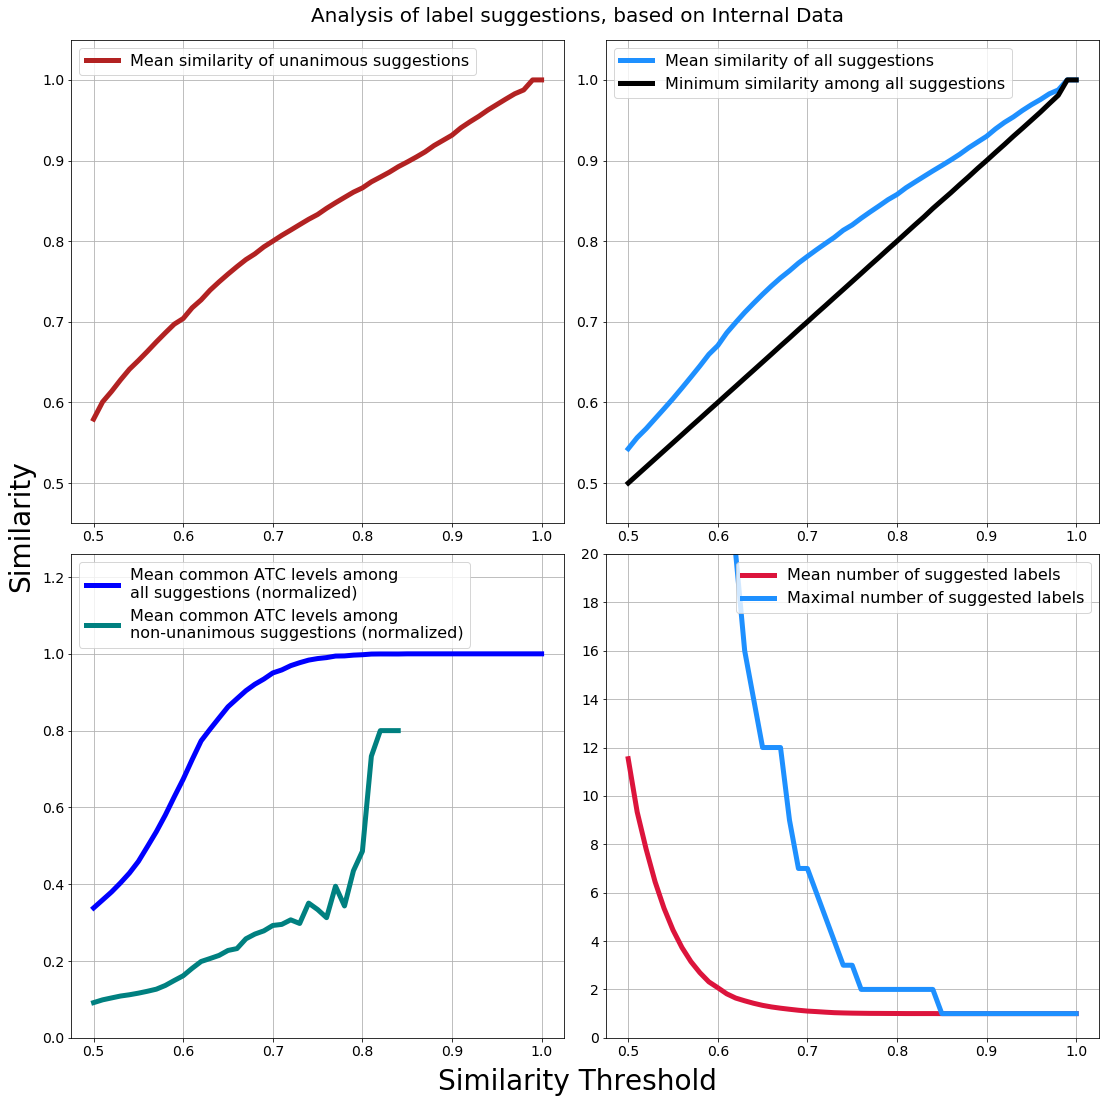

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, 
                                             figsize=(fig_width, fig_height)
                                            )

fig.tight_layout()
fig.subplots_adjust(top=0.95)  # adjusting "tightness"

title='Analysis of label suggestions, based on Internal Data'
fig.suptitle(title, fontsize=20)

colors = ['firebrick', 'dodgerblue', 
          'k', 'b', 
          'teal', 'crimson', 
          'dodgerblue', 'y']

# top left
ax1.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Unanimous mean similarity'], 
         label='Mean similarity of unanimous suggestions',
         lw=5, 
         color=colors[0])
ax1.legend(loc=2, fontsize=legend_font_size)  # 'upper right'
ax1.grid(True)
ax1.set_ylim([0.45, 1.05])

# top right
ax2.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Mean similarity'], 
         label='Mean similarity of all suggestions',
         lw=5, 
         color=colors[1])
ax2.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Min similarity'], 
         label='Minimum similarity among all suggestions',
         lw=5, 
         color=colors[2])
ax2.legend(loc=2, fontsize=legend_font_size)  # 'upper right'
ax2.grid(True)
ax2.set_ylim([0.45, 1.05])

# bottom left
ax3.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Mean common ATC levels (norm)'], 
         label='Mean common ATC levels among \nall suggestions (normalized)',
         lw=5, 
         color=colors[3])
ax3.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Mean common ATC levels, non-unanimous (norm)'], 
         label='Mean common ATC levels among \nnon-unanimous suggestions (normalized)',
         lw=5, 
         color=colors[4])
ax3.legend(loc=2, fontsize=legend_font_size)  # 'upper right'
ax3.grid(True)
ax3.set_ylim([0.0, 1.26])

# bottom right
ax4.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Mean # suggestions'], 
         label='Mean number of suggested labels',
         lw=5, 
         color=colors[5])
ax4.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Max # suggestions'], 
         label='Maximal number of suggested labels',
         lw=5, 
         color=colors[6])
ax4.legend(loc=1, fontsize=legend_font_size)  # 'upper right'
ax4.grid(True)
ax4.set_ylim([0, 20])
ax4.set_yticks(range(0,21, 2))

# Set common labels
fig.text(0.5, -0.015, 'Similarity Threshold', 
         ha='center', va='center', fontsize=x_axis_label_font_size)
fig.text(-0.015, 0.5, 'Similarity', 
         ha='center', va='center', fontsize=x_axis_label_font_size, 
         rotation='vertical')

# tick label size
ax1.tick_params(axis='both', which='major', labelsize=tick_label_font_size)
ax2.tick_params(axis='both', which='major', labelsize=tick_label_font_size)
ax3.tick_params(axis='both', which='major', labelsize=tick_label_font_size)
ax4.tick_params(axis='both', which='major', labelsize=tick_label_font_size)

# plt.show()

plt.savefig(figure_dir + 'suggestion_analysis_internal_similarities.pdf', bbox_inches='tight')

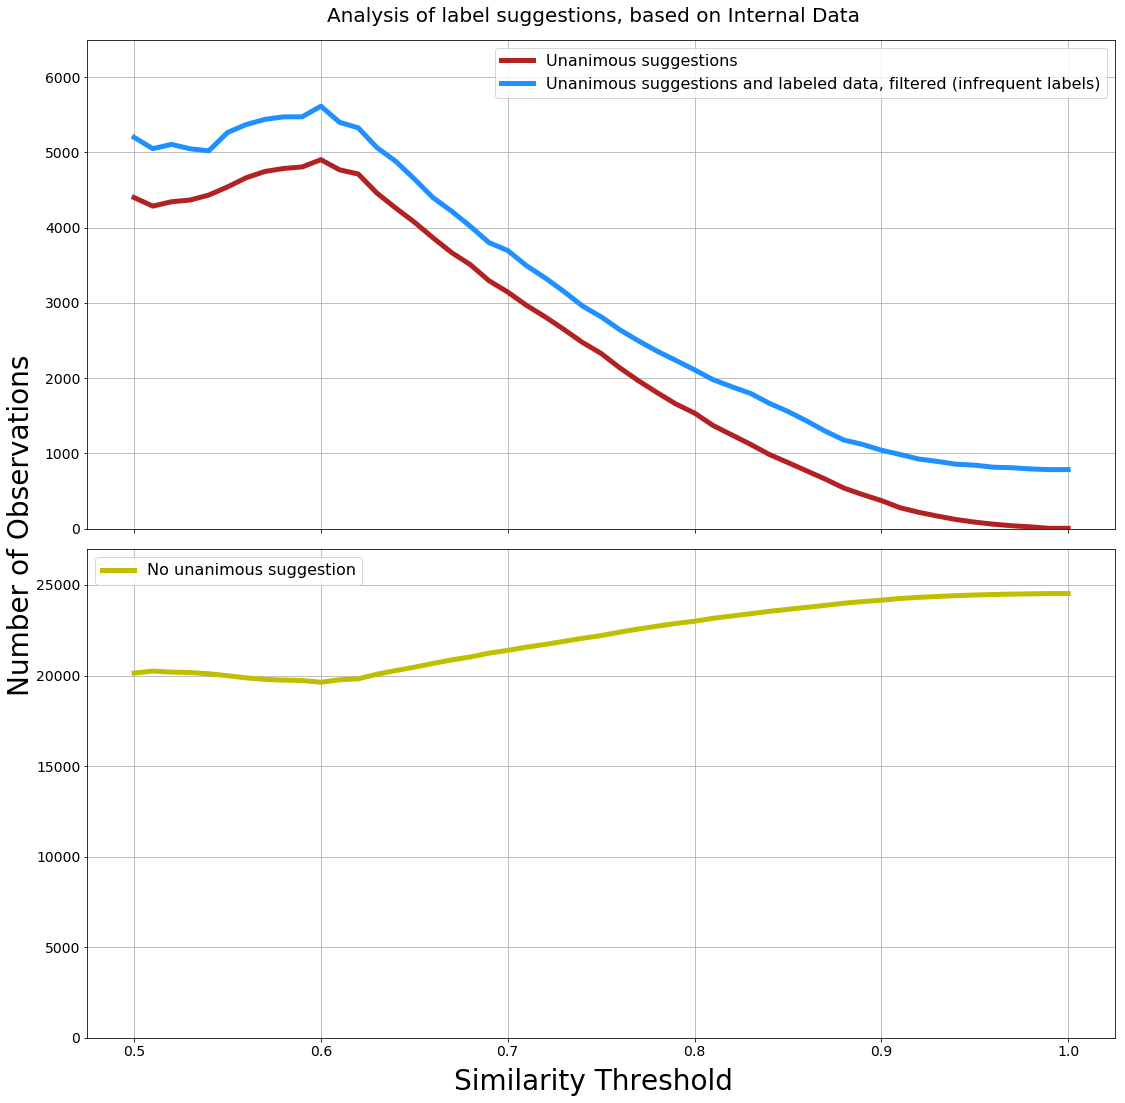

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=2, 
                         sharex=True, 
                         sharey=False,
                         figsize=(fig_width, fig_height))
# fig.subplots_adjust(0,0,1,1,0,0)

fig.tight_layout()
fig.subplots_adjust(top=0.95)  # adjusting "tightness"

# title='Analysis of label suggestions, based on Internal Data'
fig.suptitle(title, fontsize=20)


ax1.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Unanimous suggestions'], 
         label='Unanimous suggestions',
         lw=5, 
         color=colors[0])
ax1.legend(loc=2, fontsize=legend_font_size)  # 'upper right'
ax1.grid(True)
ax1.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Unanimous suggestions and labeled data, filtered (infrequent labels)'], 
         label='Unanimous suggestions and labeled data, filtered (infrequent labels)',
         lw=5, 
         color=colors[1])
ax1.legend(loc=1, fontsize=legend_font_size)  # 'upper right'
ax1.grid(True)
ax1.set_ylim([0, 6500])


ax2.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['No unanimous suggestion'], 
         label='No unanimous suggestion',
         lw=5, 
         color=colors[7])
ax2.legend(loc=2, fontsize=legend_font_size)  # 'upper right'
ax2.grid(True)
ax2.set_ylim([0, 27000])

# Set common labels
fig.text(0.5, -0.015, 'Similarity Threshold', 
         ha='center', va='center', fontsize=x_axis_label_font_size)
fig.text(-0.03, 0.5, 'Number of Observations', 
         ha='center', va='center', fontsize=x_axis_label_font_size, 
         rotation='vertical')

# tick label size
ax1.tick_params(axis='both', which='major', labelsize=tick_label_font_size)
ax2.tick_params(axis='both', which='major', labelsize=tick_label_font_size)


plt.savefig(figure_dir + 'suggestion_analysis_internal_counts.pdf', bbox_inches='tight')

In [19]:
"""
Load data from **internal and external** sources from files, after files have been generated.
Generate some plots to try and understand the label suggestions results.
"""
sim_dict_filtered = load('resources/sim_dict_filtered_5_23')
# transform the ATC codes into class instances
sim_dict_filtered = \
    {k:[(Atc_code(atc), sim) for atc, sim in v] 
     for k,v in sim_dict_filtered.items()}

In [20]:
label_suggestion_summary = []
for threshold in np.linspace(0.5,1.0, 51):
# for threshold in np.linspace(0.5,1.0, 3):
    _, _, number_of_distinct_labels, \
        labels_sim_tup = \
        get_filtered_suggestion_results(threshold, 
                                        sim_dict_filtered)
    label_suggestion_summary.append(
        record_threshold_data(
            threshold, 
            number_of_distinct_labels, 
            labels_sim_tup, 
            x_unlabeled,
            y, 
            kwargs_lin_data_init)        
        )

In [21]:
label_suggestion_summary =  \
    pd.DataFrame(label_suggestion_summary)
    
# some float formatting
label_suggestion_summary_formatted = \
    label_suggestion_summary.head(5).style.format(
        {'Mean # suggestions': '{:.2f}', 
         'Mean similari2ty': '{:.2f}', 
         'Min similarity': '{:.2f}', 
         'Unanimous mean similarity': '{:.2f}', 
         'Mean common ATC levels (norm)': '{:.2f}', 
         'Mean common ATC levels, non-unanimous (norm)': '{:.2f}'})

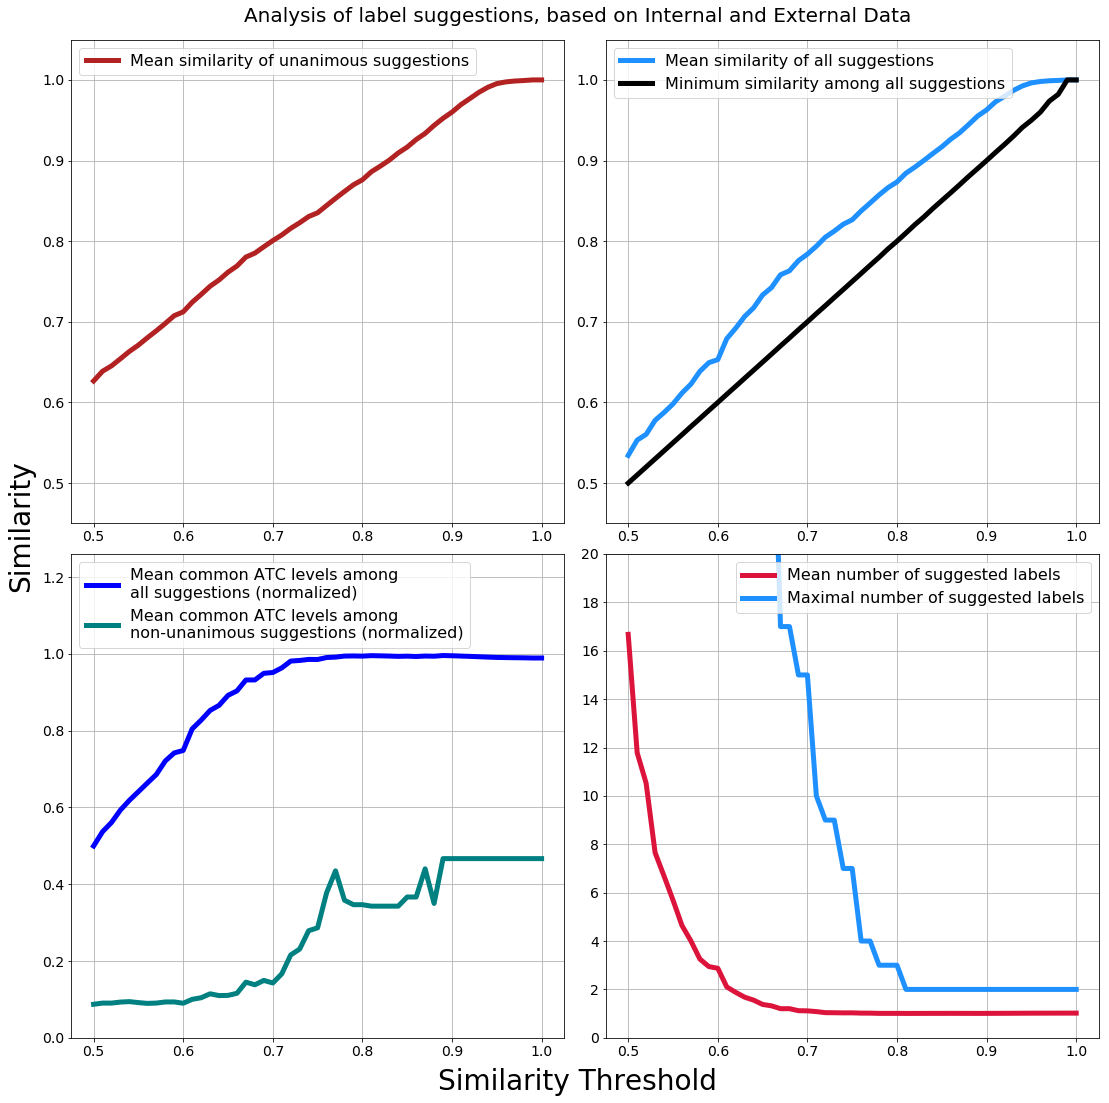

In [24]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, 
                                             figsize=(fig_width, fig_height)
                                            )
#                                              sharex='col', sharey='row')

fig.tight_layout()
fig.subplots_adjust(top=0.95)  # adjusting "tightness"

title='Analysis of label suggestions, based on Internal and External Data'
fig.suptitle(title, fontsize=20)

colors = ['firebrick', 'dodgerblue', 
          'k', 'b', 
          'teal', 'crimson', 
          'dodgerblue', 'y']

# top left
ax1.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Unanimous mean similarity'], 
         label='Mean similarity of unanimous suggestions',
         lw=5, 
         color=colors[0])
ax1.legend(loc=2, fontsize=legend_font_size)  # 'upper right'
ax1.grid(True)
ax1.set_ylim([0.45, 1.05])

# top right
ax2.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Mean similarity'], 
         label='Mean similarity of all suggestions',
         lw=5, 
         color=colors[1])
ax2.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Min similarity'], 
         label='Minimum similarity among all suggestions',
         lw=5, 
         color=colors[2])
ax2.legend(loc=2, fontsize=legend_font_size)  # 'upper right'
ax2.grid(True)
ax2.set_ylim([0.45, 1.05])

# bottom left
ax3.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Mean common ATC levels (norm)'], 
         label='Mean common ATC levels among \nall suggestions (normalized)',
         lw=5, 
         color=colors[3])
ax3.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Mean common ATC levels, non-unanimous (norm)'], 
         label='Mean common ATC levels among \nnon-unanimous suggestions (normalized)',
         lw=5, 
         color=colors[4])
ax3.legend(loc=2, fontsize=legend_font_size)  # 'upper right'
ax3.grid(True)
ax3.set_ylim([0.0, 1.26])

# bottom right
ax4.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Mean # suggestions'], 
         label='Mean number of suggested labels',
         lw=5, 
         color=colors[5])
ax4.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Max # suggestions'], 
         label='Maximal number of suggested labels',
         lw=5, 
         color=colors[6])
ax4.legend(loc=1, fontsize=legend_font_size)  # 'upper right'
ax4.grid(True)
ax4.set_ylim([0, 20])
ax4.set_yticks(range(0,21, 2))


# Set common labels
fig.text(0.5, -0.015, 'Similarity Threshold', 
         ha='center', va='center', fontsize=x_axis_label_font_size)
fig.text(-0.015, 0.5, 'Similarity', 
         ha='center', va='center', fontsize=x_axis_label_font_size, 
         rotation='vertical')

# tick label size
ax1.tick_params(axis='both', which='major', labelsize=tick_label_font_size)
ax2.tick_params(axis='both', which='major', labelsize=tick_label_font_size)
ax3.tick_params(axis='both', which='major', labelsize=tick_label_font_size)
ax4.tick_params(axis='both', which='major', labelsize=tick_label_font_size)


# plt.show()

plt.savefig(figure_dir + 'suggestion_analysis_external_similarities.pdf', bbox_inches='tight')

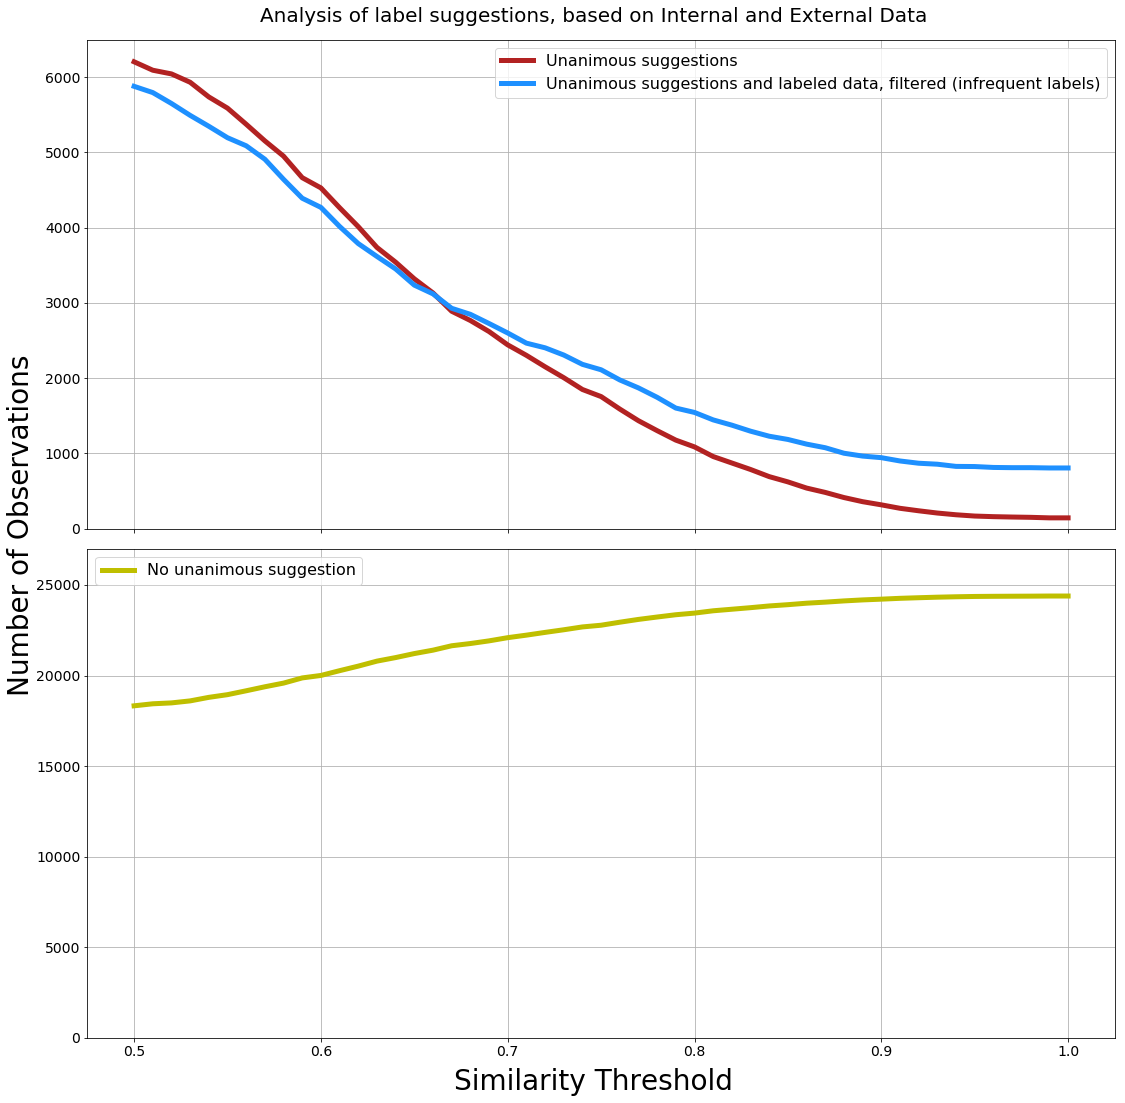

In [25]:
fig, (ax1, ax2) = plt.subplots(nrows=2, 
                         sharex=True, 
                         sharey=False,
                         figsize=(fig_width, fig_height))
# fig.subplots_adjust(0,0,1,1,0,0)

fig.tight_layout()
fig.subplots_adjust(top=0.95)  # adjusting "tightness"

# title='Analysis of label suggestions, based on Internal Data'
fig.suptitle(title, fontsize=20)

ax1.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Unanimous suggestions'], 
         label='Unanimous suggestions',
         lw=5, 
         color=colors[0])
ax1.legend(loc=2, fontsize=legend_font_size)  # 'upper right'
ax1.grid(True)
ax1.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Unanimous suggestions and labeled data, filtered (infrequent labels)'], 
         label='Unanimous suggestions and labeled data, filtered (infrequent labels)',
         lw=5, 
         color=colors[1])
ax1.legend(loc=1, fontsize=legend_font_size)  # 'upper right'
ax1.grid(True)
ax1.set_ylim([0, 6500])


ax2.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['No unanimous suggestion'], 
         label='No unanimous suggestion',
         lw=5, 
         color=colors[7])
ax2.legend(loc=2, fontsize=legend_font_size)  # 'upper right'
ax2.grid(True)
ax2.set_ylim([0, 27000])

# Set common labels
fig.text(0.5, -0.015, 'Similarity Threshold', 
         ha='center', va='center', fontsize=x_axis_label_font_size)
fig.text(-0.03, 0.5, 'Number of Observations', 
         ha='center', va='center', fontsize=x_axis_label_font_size, 
         rotation='vertical')

# tick label size
ax1.tick_params(axis='both', which='major', labelsize=tick_label_font_size)
ax2.tick_params(axis='both', which='major', labelsize=tick_label_font_size)

plt.savefig(figure_dir + 'suggestion_analysis_external_counts.pdf', bbox_inches='tight')

In [ ]:
# fill (area plot)
# http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.fill
# example:
# https://stackoverflow.com/questions/30209187/matplotlib-chart-area-vs-plot-area

In [27]:
"""
Load Patrick's assessment from file.
Plot and analyze the results, looking for an appropriate similarity threshold.
"""

fname_assessment_res = 'resources/Patricks_assessment_20170528_internal_data_WITH_SIM.csv'
assessment_res = pd.read_csv(
    fname_assessment_res, 
    delimiter=',', 
    header=0, 
    encoding='iso-8859-15', index_col='index')

# resetting index, such that the new index follows the direction of similarity
assessment_res = \
    assessment_res.sort_values('similarity').reset_index(drop=True)


assessment_grouped = \
    assessment_res[['similarity', 'patricks_assessment']].\
    groupby('patricks_assessment')


# assessment_grouped = assessment_res.groupby('patricks_assessment')
bins = lambda spread: \
    np.linspace(0.5,0.85, 
                round((0.85-0.5)/spread)+1)

In [28]:
patrick_feedback = \
    pd.DataFrame(OrderedDict([
        ('True', assessment_grouped.get_group(1).similarity),
        ('False', assessment_grouped.get_group(0).similarity)]
    ))

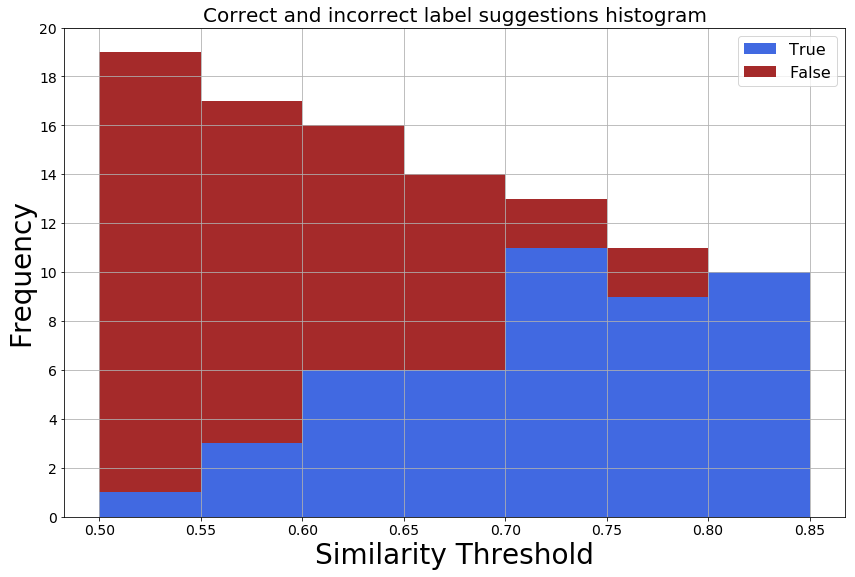

In [113]:
ax = pd.DataFrame(OrderedDict([
    ('True', assessment_grouped.get_group(1).similarity),
    ('False', assessment_grouped.get_group(0).similarity)]
    ))\
    .plot.hist(stacked=True, 
               bins=bins(0.05), 
               figsize=(14, 9), 
               color=['royalblue', 'brown'], 
               grid=True, 
               yticks = range(0,21, 2)
)

ax.set_title('Correct and incorrect label suggestions histogram', 
             fontsize=20)

ax.set_ylabel('Frequency', 
              fontsize=y_axis_label_font_size)
ax.set_xlabel('Similarity Threshold', 
              fontsize=x_axis_label_font_size)

ax.legend(loc=1,
          fontsize=legend_font_size)

ax.tick_params(axis='both', which='major', labelsize=tick_label_font_size)


plt.savefig(figure_dir + 'suggestion_feedback_hist.pdf', bbox_inches='tight')

In [31]:
"""
Write a tex file with a table
describing the 3 main variables ['FREETXT', 'CNT', 'ATC']
"""


main_data_labeled = main_data.loc[[isinstance(k, str) for k in main_data['ATC']],:]
main_data_labeled = main_data_labeled.loc[:20].sample(1, random_state=seed())

sampled_row = main_data_labeled.sample(1, random_state=seed())

# var_names = ['FREETXT', 'CNT', 'ATC']
main_data_desc = []

# FREETXT
row = OrderedDict()
row['Variable_name'] = 'FREETXT'
row['Description'] = 'Free text of the drug prescription'
# row['N_labeled'] = len(x)
# row['N_unlabeled'] = len(x_unlabeled)
row['Example'] = sampled_row['FREETXT'].values[0]
# row['Comments'] = ''
main_data_desc.append(row)

# ATC
row = OrderedDict()
row['Variable_name'] = 'ATC'
row['Description'] = 'ATC code label'
# row['N_labeled'] = len(x)
# row['N_unlabeled'] = len(x_unlabeled)
row['Example'] = sampled_row['ATC'].values[0]
# row['Comments'] = 'Manually labeled'
main_data_desc.append(row)

# CNT
row = OrderedDict()
row['Variable_name'] = 'CNT'
row['Description'] = 'Frequency of this prescription'
# row['N_labeled'] = 'Not applicable'
# row['N_unlabeled'] = 'Not applicable'
row['Example'] = sampled_row['CNT'].values[0]
# row['Comments'] = ''
main_data_desc.append(row)

main_data_desc = pd.DataFrame(main_data_desc)

with open(figure_dir + '../' + 'main_data_desc.tex', 'w') as f:
    with redirect_stdout(f):
        print(main_data_desc.to_latex(index=False, 
                                      encoding='iso-8859-15'))

In [32]:
"""
Impoting data to plot character distribution and ATC code histogram
"""

# importing data at different similarity thresholds
kwargs_lin_data_init.output_intermediate = True

kwargs_lin_data_init.use_suggestions = '0.7'
x_unk_07, x_suggest_unk_07, y_07, y_suggest_07, _, _ = \
    data_load_preprocess(**kwargs_lin_data_init)

kwargs_lin_data_init.use_suggestions = '0.8'
x_unk_08, x_suggest_unk_08, y_08, y_suggest_08, _, _ = \
    data_load_preprocess(**kwargs_lin_data_init)

kwargs_lin_data_init.use_suggestions = '0.9'
x_unk_09, x_suggest_unk_09, y_09, y_suggest_09, _, _ = \
    data_load_preprocess(**kwargs_lin_data_init)

Using label suggestion data with similarity threshold of 0.7
Using label suggestion data with similarity threshold of 0.8
Using label suggestion data with similarity threshold of 0.9


In [33]:
# convert data at different similarity thresholds
# to Counter-s
char_counter_07 = flatten_list(x_unk_07) + flatten_list(x_suggest_unk_07)
char_counter_07 = Counter(char_counter_07)
# char_counter_07 = {k:v for k,v in char_counter_07.items() 
#                    if v >= kwargs_lin_data_init.label_count_thresh}

char_counter_08 = flatten_list(x_unk_08) + flatten_list(x_suggest_unk_08)
char_counter_08 = Counter(char_counter_08)
# char_counter_08 = {k:v for k,v in char_counter_08.items() 
#                    if v >= kwargs_lin_data_init.label_count_thresh}

char_counter_09 = flatten_list(x_unk_09) + flatten_list(x_suggest_unk_09)
char_counter_09 = Counter(char_counter_09)
# char_counter_09 = {k:v for k,v in char_counter_09.items() 
#                    if v >= kwargs_lin_data_init.label_count_thresh}

char_counter_10 = flatten_list(x_unk_07)
char_counter_10 = Counter(char_counter_10)
# char_counter_10 = {k:v for k,v in char_counter_10.items() 
#                    if v >= kwargs_lin_data_init.label_count_thresh}

atc_counter_07 = Counter(y_07 + y_suggest_07)
atc_counter_07_filtered = \
    {k:v for k,v in atc_counter_07.items() 
     if v >= kwargs_lin_data_init.label_count_thresh}

atc_counter_08 = Counter(y_08 + y_suggest_08)
atc_counter_08_filtered = \
    {k:v for k,v in atc_counter_08.items() 
     if v >= kwargs_lin_data_init.label_count_thresh}

atc_counter_09 = Counter(y_09 + y_suggest_09)
atc_counter_09_filtered = \
    {k:v for k,v in atc_counter_09.items() 
     if v >= kwargs_lin_data_init.label_count_thresh}

atc_counter_10 = Counter(y_07)
atc_counter_10_filtered = \
    {k:v for k,v in atc_counter_10.items() 
     if v >= kwargs_lin_data_init.label_count_thresh}

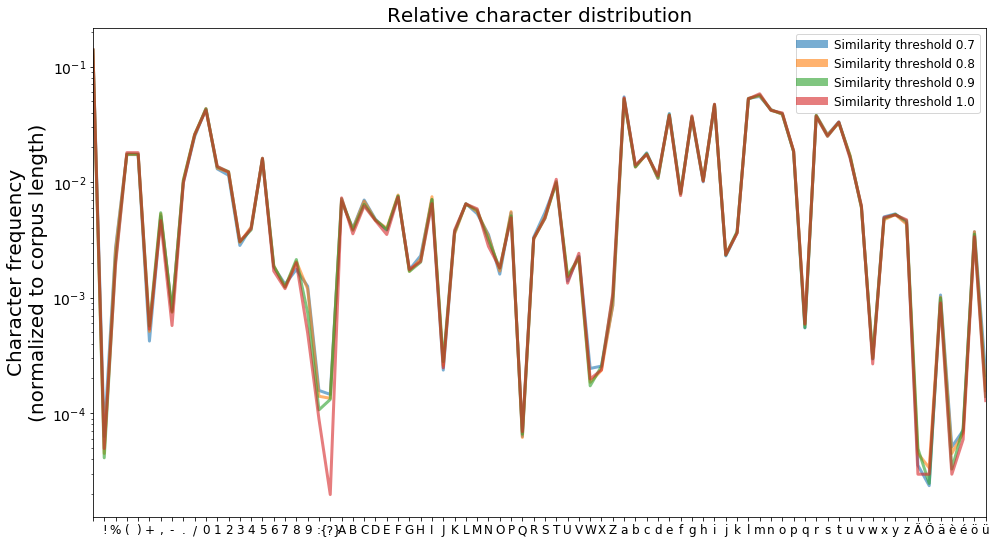

In [110]:
char_counter_df = \
    pd.DataFrame([char_counter_07, 
                  char_counter_08, 
                  char_counter_09, 
                  char_counter_10], 
                 index=['similarity_07', 
                        'similarity_08', 
                        'similarity_09', 
                        'similarity_10']).fillna(0)

char_counter_df = char_counter_df.transpose()

# normalize by dividing in by the total number of characters
char_counter_df = \
    char_counter_df.div(char_counter_df.sum(axis=0), axis=1)

# change a single index entry (UNK)
as_list = char_counter_df.index.tolist()
idx = as_list.index('<unk-char>')
as_list[idx] = '{?}'
char_counter_df.index = as_list

ax = char_counter_df.plot(
    figsize=(16, 9), 
#     color=['royalblue', 'brown'], 
    logy=True,
    lw=3,
    alpha=0.6,
#     grid=True
)

leg = ax.legend(['Similarity threshold 0.7', 
           'Similarity threshold 0.8', 
           'Similarity threshold 0.9', 
           'Similarity threshold 1.0'], 
          loc=1,
          fontsize=legend_font_size-4)

# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(8)

#index mashing, to get index as xticks labels
width = 0.0       # the width of the bars
index_ser = np.arange(len(char_counter_df))  # arrange indices for x axis
ax.set_xticks(index_ser + width / 2)
ax.set_xticklabels(char_counter_df.index.values, 
                   rotation=0, 
                   size=12)

ax.set_ylabel('Character frequency\n(normalized to corpus length)', 
              fontsize=y_axis_label_font_size-8)
ax.set_title('Relative character distribution', 
             fontsize=20)

ax.tick_params(axis='y', which='major', 
               labelsize=tick_label_font_size)  # axis : {'x', 'y', 'both'}

# plt.show()
plt.savefig(figure_dir + 'char_dist.pdf', bbox_inches='tight')

In [54]:
plt.clf()

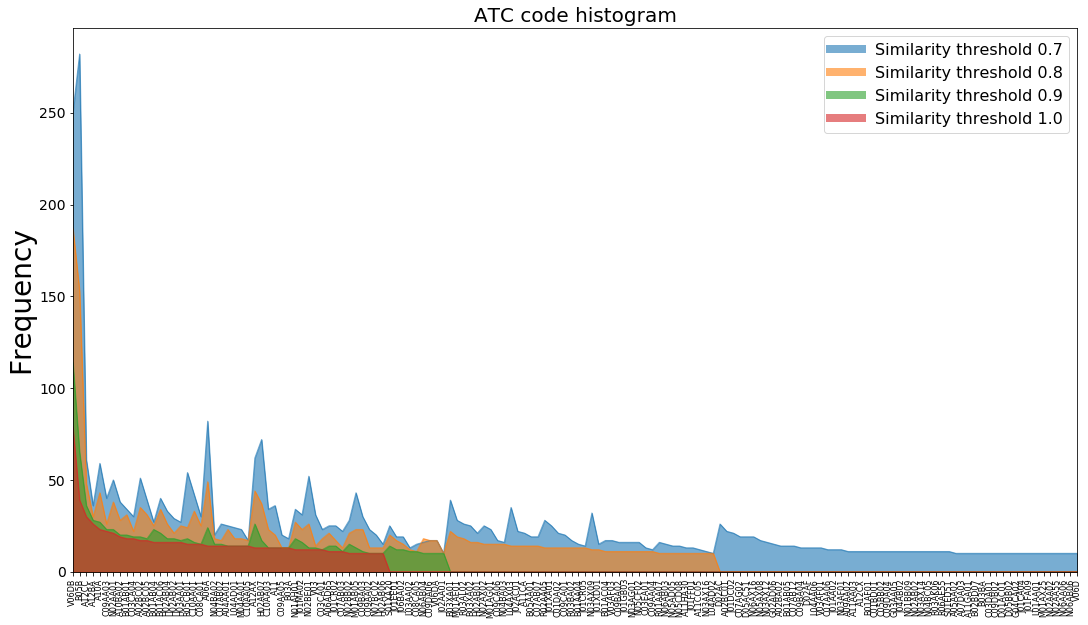

In [76]:
atc_counter_df = \
    pd.DataFrame([atc_counter_07_filtered, 
                  atc_counter_08_filtered, 
                  atc_counter_09_filtered, 
                  atc_counter_10_filtered], 
                 index=['similarity_07', 
                        'similarity_08', 
                        'similarity_09', 
                        'similarity_10']).fillna(0)

atc_counter_df = atc_counter_df.transpose()

# convert to int (for some reason, pandas converted to float)
atc_counter_df = atc_counter_df.astype(int)

# sort according to the non-augmented data-set (similarity 1.0)
atc_counter_df.sort_values(['similarity_10', 
                            'similarity_09', 
                            'similarity_08', 
                            'similarity_07'], 
                           ascending=False, 
                           inplace=True)

ax = atc_counter_df.plot(
    kind='area',
    figsize=(18, 10), 
    fontsize=12,  # affects the axis tick sizes
    lw=1,
    alpha=0.6,
    stacked=False,
)

#index mashing, to get index as xticks labels
width = 0.0       # the width of the bars
index_ser = np.arange(len(atc_counter_df))  # arrange indices for x axis
ax.set_xticks(index_ser + width / 2)
ax.set_xticklabels(atc_counter_df.index.values, 
                   rotation=90, 
                   size=8)

leg =ax.legend(['Similarity threshold 0.7', 
                'Similarity threshold 0.8', 
                'Similarity threshold 0.9', 
                'Similarity threshold 1.0'], 
                loc=1,
                fontsize=legend_font_size, )

# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(8)

# help(ax.legend)

ax.set_ylabel('Frequency', 
              fontsize=y_axis_label_font_size)
ax.set_title('ATC code histogram', 
             fontsize=20)

ax.tick_params(axis='y', which='major', 
               labelsize=tick_label_font_size)  # axis : {'x', 'y', 'both'}

# plt.show()
plt.savefig(figure_dir + 'atc_histogram.pdf', bbox_inches='tight')

In [77]:
# get a stats table of filtered / unfiltered data, at different similarity thresholds
counters = [atc_counter_07, 
            atc_counter_08, 
            atc_counter_09, 
            atc_counter_10]

counters_filtered = [atc_counter_07_filtered, 
                     atc_counter_08_filtered, 
                     atc_counter_09_filtered, 
                     atc_counter_10_filtered]

similarities = ['0.7', 
                '0.8', 
                '0.9', 
                '1.0']

# sim_threshold_data_stats_unfiltered = []
# sim_threshold_data_stats_filtered = []
sim_threshold_data_stats = []

for counter, counter_filtered, sim in \
    zip(counters, counters_filtered, similarities):
        row = OrderedDict()
        # unfiltered
        row['Similarity'] = sim
        row['Filtered?'] = 'Unfiltered'
        row['Number of observations'] = sum(counter.values())
        row['Number of labels'] = len(list(counter.keys()))
        row['Min-mean-max observations per label'] = '{}-{:.2f}-{}'.format(
            min(counter.values()), 
            np.mean(list(counter.values())), 
            max(counter.values())
        )
#         sim_threshold_data_stats_unfiltered.append(row)
        sim_threshold_data_stats.append(row)

        row = OrderedDict()
        # filtered
        row['Similarity'] = sim
        row['Filtered?'] = 'Filtered'
        row['Number of observations'] = sum(counter_filtered.values())
        row['Number of labels'] = len(list(counter_filtered.keys()))
        row['Min-mean-max observations per label'] = '{}-{:.2f}-{}'.format(
            min(counter_filtered.values()), 
            np.mean(list(counter_filtered.values())), 
            max(counter_filtered.values())
        )
#         sim_threshold_data_stats_filtered.append(row)
        sim_threshold_data_stats.append(row)

sim_threshold_data_stats = \
    pd.DataFrame(sim_threshold_data_stats)

# sim_threshold_data_stats
# sim_threshold_data_stats.set_index(['Similarity', 'Filtered?'])
# sim_threshold_data_stats.set_index(['Similarity'])

sim_threshold_data_stats = \
    sim_threshold_data_stats.pivot(index='Similarity', columns='Filtered?')

with open(figure_dir + '../' + 'sim_threshold_data_stats.tex', 'w') as f:
    with redirect_stdout(f):
        print(sim_threshold_data_stats.to_latex(index=False))

In [5]:
"""
Load SVM training results from CSV files
Plot MRR and accuracy vs similarity thresholds
"""

sub_dir_svm = 'svm_results/'

# get a list of file names in sub_dir_svm
svm_summary_files = [fname
                 for fname 
                 in next(os.walk(sub_dir_svm))][2]

svm_summary_files = [sub_dir_svm + fname 
                     for fname in svm_summary_files]

svm_results = []
for file in svm_summary_files:
    data_table = pd.read_csv(file)
    row = OrderedDict()
    row['name'] = file.split('summary_')[1]  # split the file name
    row['Accuracy'] = data_table['Accuracy'][0]
    row['Mean Reciprocal Rank'] = data_table['Mean Reciprocal Rank'][0]
    row['kernel'] = data_table['kernel'][0]
    row['c'] = data_table['C'][0]
    svm_results.append(row)

In [6]:
svm_results_summary = pd.DataFrame(svm_results)
svm_results_summary = \
    svm_results_summary.sort_values(by='name', ascending=False)

# get similarity str
svm_results_summary['Similarity'] = svm_results_summary['name'].map(lambda x: x.split('_')[1])
svm_results_summary['Similarity'] = \
    svm_results_summary['Similarity'].map(lambda x: '10' if x == 'suggest' else x)
# replace with correct float
svm_results_summary['Similarity'] = \
    svm_results_summary['Similarity'].astype(int).div(10)

def get_svm_data_type_str(input_str):
    str_list = input_str.split('_')
    if 'BOC' in str_list:
        return 'No ngrams'
    if 'FILTER.csv' in str_list:
        return 'Ngrams near-no-filter'
    else:
        return 'Ngrams'

# get data type (BOC / ngrams / near-no-filter)
svm_results_summary['Data_type'] = svm_results_summary['name'].map(get_svm_data_type_str)

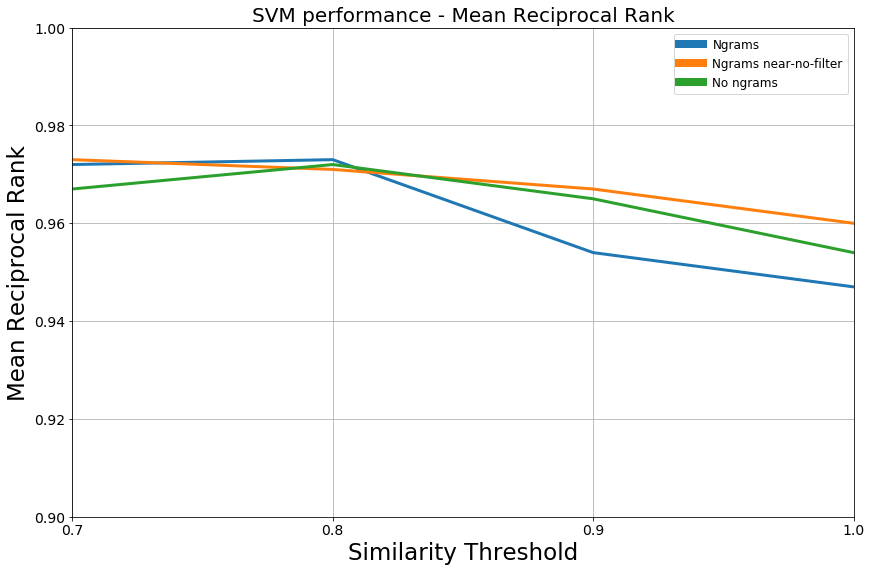

In [9]:
ax = svm_results_summary.pivot('Similarity', 'Data_type', 'Mean Reciprocal Rank')\
    .plot(
        figsize=(14,9),
        ylim=(0.9, 1.0), 
        linewidth=3, 
        xticks = (0.7, 0.8, 0.9, 1.0),
        grid=True
    )

ax.set_title('SVM performance - Mean Reciprocal Rank', 
             fontsize=20)

ax.set_xlabel('Similarity Threshold', 
              fontsize=x_axis_label_font_size-5)
ax.set_ylabel('Mean Reciprocal Rank', 
              fontsize=y_axis_label_font_size-5)

ax.tick_params(axis='both', which='major', 
               labelsize=tick_label_font_size)  # axis : {'x', 'y', 'both'}

leg =ax.legend(loc=1,
               fontsize=legend_font_size-4)

# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(8)


# plt.show()
plt.savefig(figure_dir + 'SVM_performance_mrr.pdf', bbox_inches='tight')

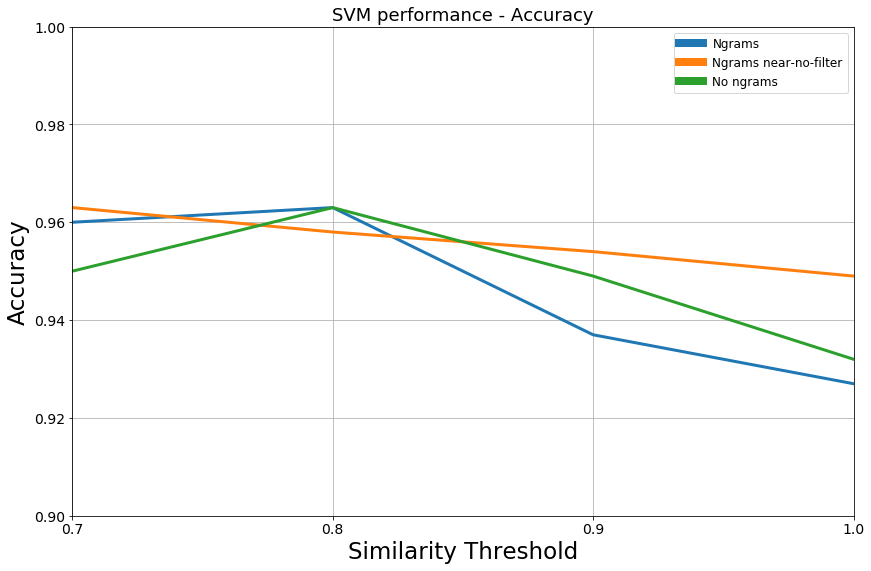

In [10]:
ax = svm_results_summary.pivot('Similarity', 'Data_type', 'Accuracy')\
    .plot(
        figsize=(14,9),
        ylim=(0.9, 1.0), 
        linewidth=3, 
        xticks = (0.7, 0.8, 0.9, 1.0),
        grid=True
    )

ax.set_title('SVM performance - Accuracy', 
             fontsize=18)

ax.set_xlabel('Similarity Threshold', 
              fontsize=x_axis_label_font_size-5)
ax.set_ylabel('Accuracy', 
              fontsize=y_axis_label_font_size-5)

ax.tick_params(axis='both', which='major', 
               labelsize=tick_label_font_size)  # axis : {'x', 'y', 'both'}

leg =ax.legend(loc=1,
               fontsize=legend_font_size-4)

# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(8)


# plt.show()
plt.savefig(figure_dir + 'SVM_performance_accuracy.pdf', bbox_inches='tight')

In [15]:
"""
Load RNN training results from CSV files

"""
sub_dir_rnn = 'rnn_results/'

# example runs
run_char_embed = "run_LSTM,bidir=F,tf.tanh,keep_infreq_labels=F,learn_rate=1.0E-01,keep_prob=1.0,char_embed_dim=4,hidden_state_size=64,l2_weight_reg=0.0E+00,target_rep_weight=NA,tag_Mean_Reciprocal_Rank-Mean_Reciprocal_Rank_test.csv"
run_one_hot =    "run_LSTM,bidir=F,tf.tanh,keep_infreq_labels=F,learn_rate=1.0E-01,keep_prob=1.0,one_hot,hidden_state_size=64,l2_weight_reg=0.0E+00,target_rep_weight=NA,tag_Mean_Reciprocal_Rank-Mean_Reciprocal_Rank_test.csv"
run_lr_03 =      "run_LSTM,bidir=F,tf.tanh,keep_infreq_labels=F,learn_rate=1.0E-03,keep_prob=1.0,one_hot,hidden_state_size=8,l2_weight_reg=0.0E+00,target_rep_weight=NA,tag_Mean_Reciprocal_Rank-Mean_Reciprocal_Rank_test.csv"
run_lr_01 =      "run_LSTM,bidir=F,tf.tanh,keep_infreq_labels=F,learn_rate=1.0E-01,keep_prob=1.0,one_hot,hidden_state_size=8,l2_weight_reg=0.0E+00,target_rep_weight=NA,tag_Mean_Reciprocal_Rank-Mean_Reciprocal_Rank_test.csv"

run_char_embed = \
    pd.read_csv(sub_dir_rnn + run_char_embed)
    
run_one_hot = \
    pd.read_csv(sub_dir_rnn + run_one_hot)

run_lr_03 = \
    pd.read_csv(sub_dir_rnn + run_lr_03)

run_lr_01 = \
    pd.read_csv(sub_dir_rnn + run_lr_01)

# summaries, per sim threshold
summary_sim_07 = "experiments_sim_070.csv"
summary_sim_08 = "experiments_sim_080.csv"
summary_sim_09 = "experiments_sim_090.csv"
summary_sim_10 = "experiments_sim_100.csv"

summary_sim_07 = \
    pd.read_csv(sub_dir_rnn + summary_sim_07, sep=';')

summary_sim_08 = \
    pd.read_csv(sub_dir_rnn + summary_sim_08, sep=';')

summary_sim_09 = \
    pd.read_csv(sub_dir_rnn + summary_sim_09, sep=';')

summary_sim_10 = \
    pd.read_csv(sub_dir_rnn + summary_sim_10, sep=';')

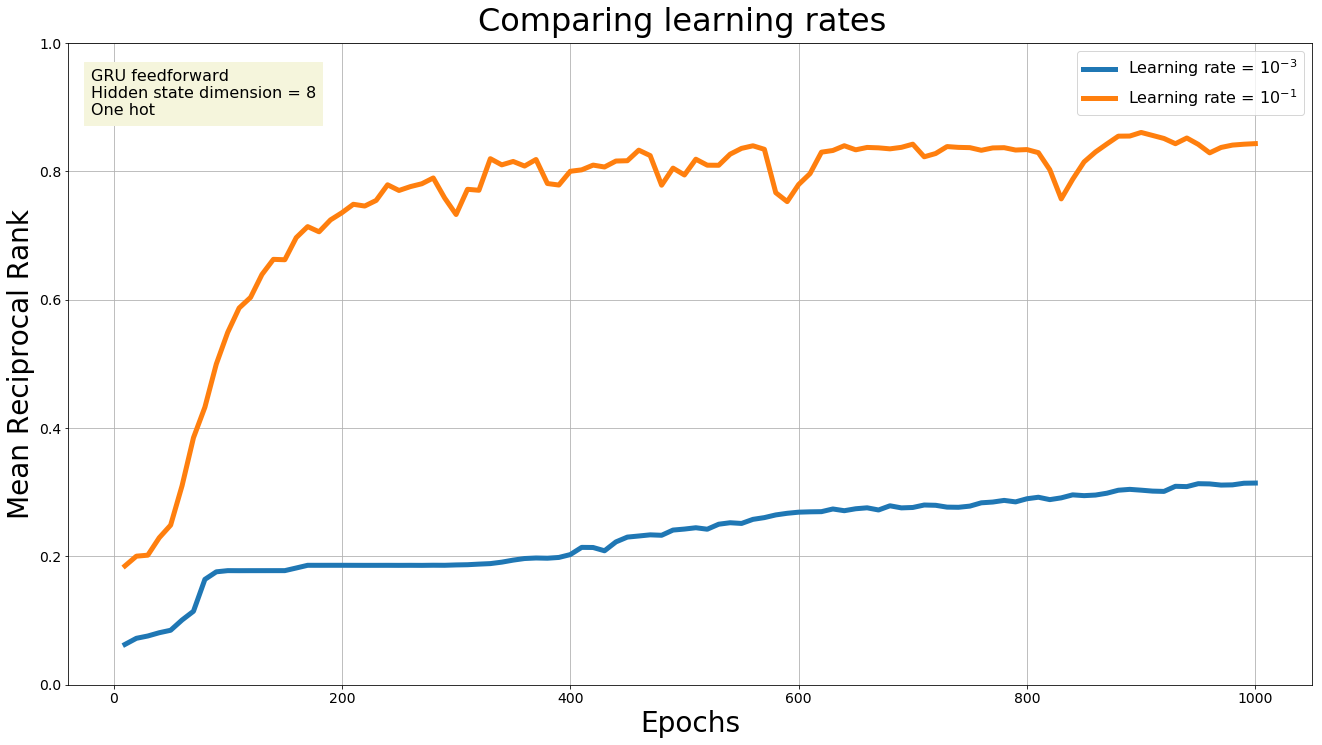

In [16]:
fig, (ax1) = plt.subplots(nrows=1, 
                          ncols=1,
                          figsize=(18, 10))

fig.tight_layout()
fig.subplots_adjust(top=0.93)  # adjusting "tightness"

title='Comparing learning rates'
fig.suptitle(title, fontsize=32)

ax1.plot(run_lr_03['Step'], 
         run_lr_03['Value'], 
         label=r'Learning rate = $10^{-3}$',
         lw=5)
ax1.legend(loc=2, fontsize=legend_font_size)  # 'upper right'
ax1.grid(True)
ax1.plot(run_lr_01['Step'], 
         run_lr_01['Value'], 
         label=r'Learning rate = $10^{-1}$',
         lw=5)
ax1.legend(loc=1, fontsize=legend_font_size)  # 'upper right'
ax1.grid(True)
ax1.set_ylim(0, 1.0)


# Set top-right text box
fig.text(0.13, 0.86, 'GRU feedforward\nHidden state dimension = 8\nOne hot', 
         multialignment='left',
         backgroundcolor='beige',
         ha='center', 
         va='center', 
         fontsize=16)

ax1.set_xlabel('Epochs', 
              fontsize=x_axis_label_font_size)
ax1.set_ylabel('Mean Reciprocal Rank', 
              fontsize=x_axis_label_font_size)

ax1.tick_params(axis='both', which='major', 
               labelsize=tick_label_font_size)  # axis : {'x', 'y', 'both'}


plt.savefig(figure_dir + 'tensorboard_compare_lr.pdf', bbox_inches='tight')

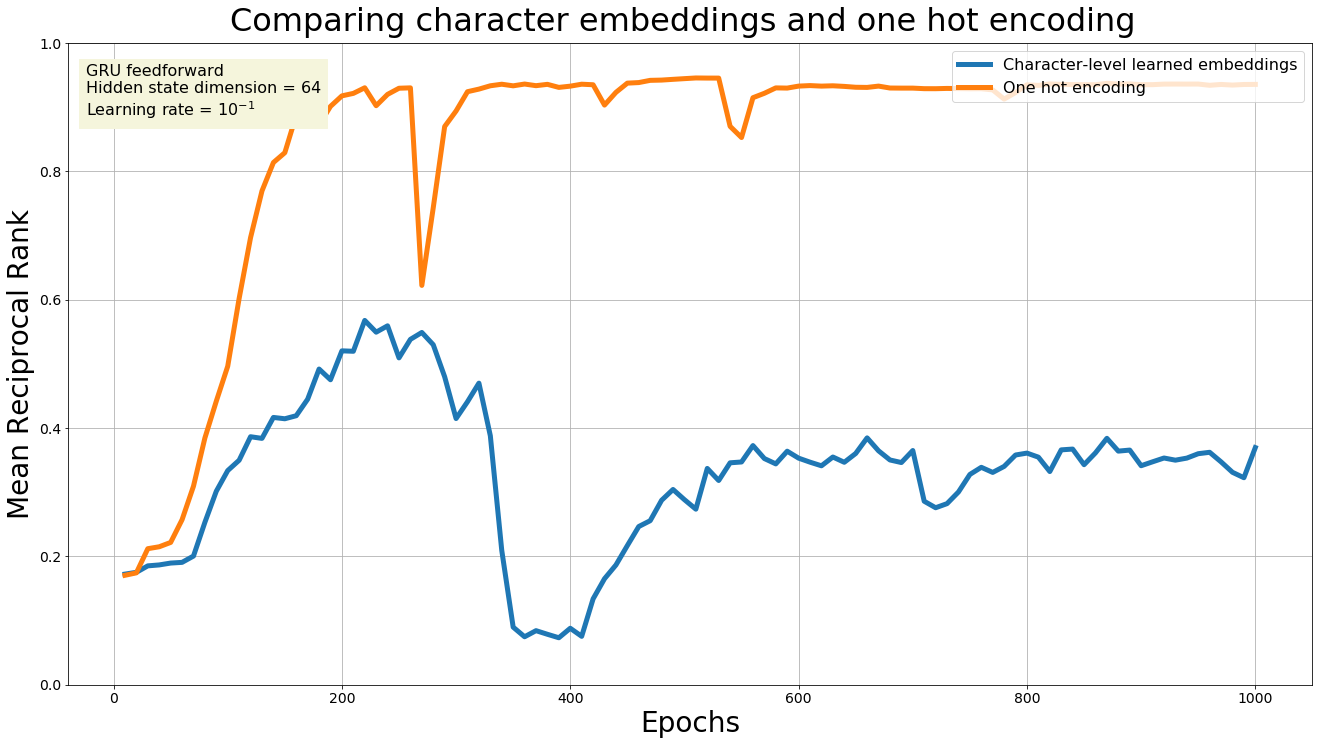

In [17]:
fig, (ax1) = plt.subplots(nrows=1, 
                          ncols=1,
                          figsize=(18, 10))

fig.tight_layout()
fig.subplots_adjust(top=0.93)  # adjusting "tightness"

title='Comparing character embeddings and one hot encoding'
fig.suptitle(title, fontsize=32)

ax1.plot(run_char_embed['Step'], 
         run_char_embed['Value'], 
         label='Character-level learned embeddings',
         lw=5)
ax1.legend(loc=2, fontsize=legend_font_size)  # 'upper right'
ax1.grid(True)
ax1.plot(run_one_hot['Step'], 
         run_one_hot['Value'], 
         label='One hot encoding',
         lw=5)
ax1.legend(loc=1, fontsize=legend_font_size)  # 'upper right'
ax1.grid(True)
ax1.set_ylim(0, 1.0)


# Set top-right text box
fig.text(0.13, 0.86, 'GRU feedforward\nHidden state dimension = 64\n' +\
         r'Learning rate = $10^{-1}$', 
         multialignment='left',
         backgroundcolor='beige',
         ha='center', 
         va='center', 
         fontsize=16)

ax1.set_xlabel('Epochs', 
              fontsize=x_axis_label_font_size)
ax1.set_ylabel('Mean Reciprocal Rank', 
              fontsize=x_axis_label_font_size)

ax1.tick_params(axis='both', which='major', 
               labelsize=tick_label_font_size)  # axis : {'x', 'y', 'both'}

plt.savefig(figure_dir + 'tensorboard_compare_char_embed_one_hot.pdf', bbox_inches='tight')

In [18]:
# create summaries from ALL RNN runs

def add_columns_to_df(pandas_df):
    """
    Add columns, information based on model string
    """
    pandas_df['Model type'] = \
        pandas_df['Model_str'].apply(lambda x: 'GRU' if 'GRU' in x else 'LSTM')

    pandas_df['Bidirectional'] = \
        pandas_df['Model_str'].apply(lambda x: 'T' if 'bidir=T' in x else 'F')
    
    return pandas_df

# quickly filter pandas df with certain column value
filter_pd_df = lambda df, col, val: df[df[col] == val]

summary_sim_dfs = [summary_sim_07, 
                   summary_sim_08, 
                   summary_sim_09, 
                   summary_sim_10]

for pandas_df in summary_sim_dfs:
    add_columns_to_df(pandas_df)

In [19]:
summary_sim_dict = OrderedDict()
for sim, model, bidir in product(['07', '08', '09', '10'],
                                 ['LSTM', 'GRU'], 
                                 ['T', 'F']):
    
    # set some strings and vars
#     print(sim, model, bidir)
    summary_name = 'summary_sim_{}'.format(sim)
    data = eval(summary_name)  # the pandas df
    data_str = 'sim_{}_{},bidir={}'.format(sim, model, bidir)
    
    # filter data
    temp_df = filter_pd_df(data, 'Model type', model)
    temp_df = filter_pd_df(temp_df, 'Bidirectional', bidir)
    
    # store
    summary_sim_dict[data_str] = temp_df

In [20]:
summary_mrr_at_cost = []
summary_mrr_at_mrr = []

# MRR @ optimal cost
for k,v in summary_sim_dict.items():
    sim = k.split('_')[1]
    sort_col = 'MRR @ optimal cost'
    
    new_val = \
        v.sort_values(sort_col, 
                      ascending=False).\
            head(1)[['Model_str', 
                     sort_col, 
                     'Model type', 
                     'Bidirectional']]
    new_val['Similarity'] = int(sim) / 10
    summary_mrr_at_cost.append(new_val)
    
# MRR @ optimal MRR
for k,v in summary_sim_dict.items():
    sim = k.split('_')[1]
    sort_col = 'MRR @ optimal MRR'
    
    new_val = \
        v.sort_values(sort_col, 
                      ascending=False).\
            head(1)[['Model_str', 
                     sort_col, 
                     'Model type', 
                     'Bidirectional']]
    new_val['Similarity'] = int(sim) / 10
    summary_mrr_at_mrr.append(new_val)

summary_mrr_at_cost = \
    pd.concat(summary_mrr_at_cost)

summary_mrr_at_mrr = \
    pd.concat(summary_mrr_at_mrr)

In [21]:
# SVM results
summary_mrr_svm = filter_pd_df(svm_results_summary, 
                               'Data_type', 
                               'Ngrams near-no-filter')

summary_mrr_svm = summary_mrr_svm[['name', 
                                   'Mean Reciprocal Rank', 
                                   'Similarity']]

summary_mrr_svm = \
    summary_mrr_svm.rename(columns={'name': 'Model_str', 
                                    'Mean Reciprocal Rank': 'MRR @ optimal MRR'})

summary_mrr_svm['Model type'] = 'SVM'
summary_mrr_svm['Bidirectional'] = 'NA'

In [22]:
# plot MRR @ optimal MRR results, with SVM
summary_mrr_at_mrr = pd.concat([summary_mrr_at_mrr, summary_mrr_svm])

summary_mrr_at_mrr['exper'] = \
    summary_mrr_at_mrr['Model type'] + ',' + summary_mrr_at_mrr['Bidirectional']
    
summary_mrr_at_mrr_df_to_plot = \
    summary_mrr_at_mrr.pivot(columns='exper', index='Similarity', values='MRR @ optimal MRR')
    
summary_mrr_at_mrr_df_to_plot.rename(columns={'SVM,NA': 'SVM', 
                                              'GRU,F': 'GRU feed-forward', 
                                              'GRU,T': 'GRU bidirectional', 
                                              'LSTM,F': 'LSTM feed-forward', 
                                              'LSTM,T': 'LSTM bidirectional'}, inplace=True)

In [24]:
summary_mrr_at_mrr[summary_mrr_at_mrr.Similarity == 0.7]

,Bidirectional,MRR @ optimal MRR,Model type,Model_str,Similarity,exper
59,T,0.965225,LSTM,"LSTM,bidir=T,noisy_tanh,learn_p=F,noise_alpha=...",0.7,"LSTM,T"
24,F,0.969851,LSTM,"LSTM,bidir=F,noisy_tanh,learn_p=F,noise_alpha=...",0.7,"LSTM,F"
0,T,0.978946,GRU,"GRU,bidir=T,noisy_tanh,learn_p=F,noise_alpha=0...",0.7,"GRU,T"
4,F,0.975686,GRU,"GRU,bidir=F,noisy_tanh,learn_p=F,noise_alpha=0...",0.7,"GRU,F"
5,NA,0.973000,SVM,suggest_07_WITH_NGRAMS_near_NO_FILTER.csv,0.7,"SVM,NA"


In [27]:
summary_sim_dict['sim_07_LSTM,bidir=F'].head(1)\
.values[0]

array([317,
       'LSTM,bidir=F,noisy_tanh,learn_p=F,noise_alpha=0.9,noise_half_normal=F,keep_infreq_labels=F,learn_rate=1.0E-02,keep_prob=0.5,one_hot,hidden_state_size=128,l2_weight_reg=1.0E-03,target_rep_weight=0.5',
       0.7036548256874084, 0.9658498764038086, 0.9564102292060852, 970,
       0.7079520225524902, 0.9698507189750672, 0.962820529937744, 980,
       0.7079520225524902, 0.9698507189750672, 0.962820529937744, 980,
       'LSTM', 'F'], dtype=object)

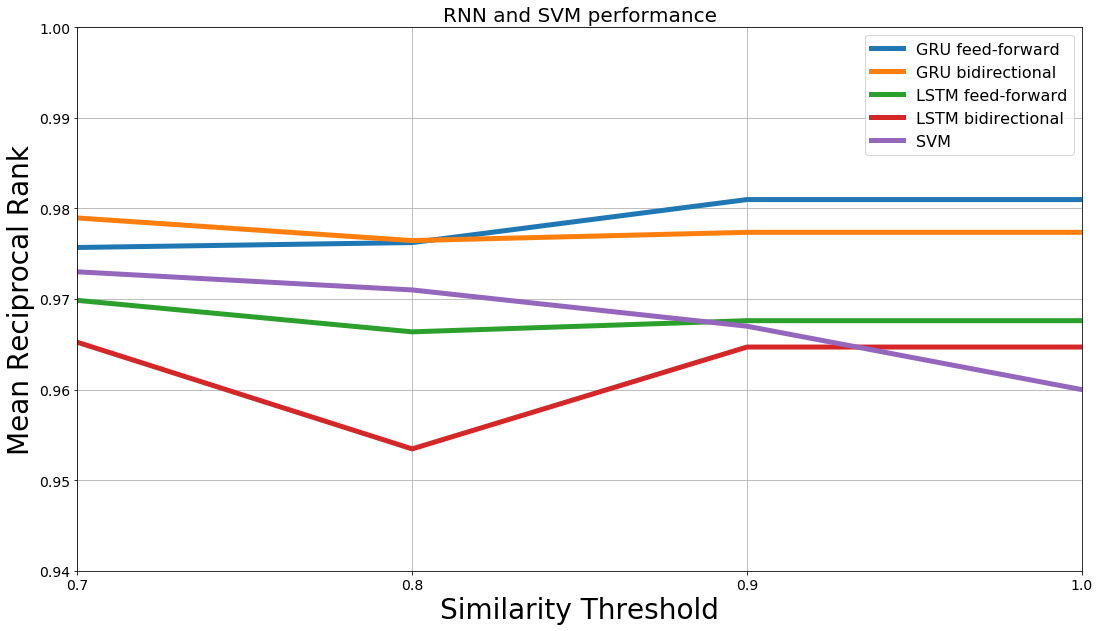

In [25]:
fig = summary_mrr_at_mrr_df_to_plot.plot(
    figsize=(18, 10), 
    lw=5,
    xticks = (0.7, 0.8, 0.9, 1.0)
    )

fig.axes.grid(True)
fig.axes.set_ylim(0.94, 1.0)

title='RNN and SVM performance'
fig.set_title(title, fontsize=20)

fig.axes.legend(loc=1, fontsize=legend_font_size) 

# Set top-right text box
# fig.text(0.13, 0.88, 'Hidden state dimension = 64\nLearning rate = 10^-1', 
#          multialignment='left',
#          backgroundcolor='beige',
#          ha='center', 
#          va='center', 
#          fontsize=16)

fig.axes.set_xlabel('Similarity Threshold', 
                    fontsize=x_axis_label_font_size)
fig.axes.set_ylabel('Mean Reciprocal Rank', 
                    fontsize=y_axis_label_font_size)

fig.axes.tick_params(axis='both', which='major', 
               labelsize=tick_label_font_size)  # axis : {'x', 'y', 'both'}


plt.savefig(figure_dir + 'rnn_svm_sim_compare.pdf', bbox_inches='tight')
# plt.show()

In [46]:
"""
Read in results of MRR per ATC code
"""

collected_results_per_atc_code_dir = 'rnn_results/results_per_atc_code/'

results_files = next(os.walk(collected_results_per_atc_code_dir))[2]
results_files = [collected_results_per_atc_code_dir + fname 
                 for fname in results_files]

In [310]:
mrr_per_atc_code = \
    [fname 
     for fname in results_files 
     if 'rnn_svm_results_per_atc_code' in fname]

obs_num_per_atc_code = \
    [fname 
     for fname in results_files 
     if 'rnn_svm_obs_num_per_atc_code' in fname]

In [311]:
mrr_per_atc_code = \
    pd.DataFrame(flatten_list([load(fname) for fname in mrr_per_atc_code])).fillna(-0.1)

mrr_per_atc_code = \
    mrr_per_atc_code.set_index(['Similarity', 'Model type']).T

obs_num_per_atc_code = \
    pd.DataFrame(flatten_list([load(fname) for fname in obs_num_per_atc_code])).fillna(0)
    
# keep only 1 observation per similarity level
obs_num_per_atc_code = obs_num_per_atc_code[obs_num_per_atc_code['Model type'] == 'SVM']
obs_num_per_atc_code['Model type'] = 'Size of test set'

obs_num_per_atc_code = \
    obs_num_per_atc_code.set_index(['Similarity', 'Model type']).T

# convert to int (for some reason, pandas converted to float)
obs_num_per_atc_code = obs_num_per_atc_code.astype(int)

In [312]:
mrr_per_atc_code

Similarity       1.0                           0.8                    
Model type       SVM       GRU      LSTM       SVM       GRU      LSTM
A02BC02     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
A02BC05     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
A04AA01     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
A06A        0.750000  0.833333  0.537037  0.805556  0.917929  0.761905
A06AD65     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
A10A        1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
A10BA02     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
A11         0.384921  0.681818  0.507576  0.813333  0.808696  0.810526
A12AX       1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
A12BA       0.866667  1.000000  1.000000  1.000000  1.000000  1.000000
A12CC       0.904762  1.000000  0.868132  0.944444  1.000000  1.000000
B01AB01     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
B01AB04     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
B01AC06     0.833333  1.000000  1.000000  1.000000  1.000000  1.000000
B03A        1.000000  1.000000  0.733333  1.000000  0.690476  1.000000
B05B        1.000000  1.000000  0.901235  1.000000  1.000000  1.000000
C03CA01     0.683333  1.000000  0.675439  1.000000  1.000000  1.000000
C03CA04     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
C07AB02     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
C07AB03     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
C08CA01     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
C09AA02     1.000000  1.000000  1.000000  1.000000  0.833333  0.690476
C09AA03     1.000000  0.804762  1.000000  1.000000  1.000000  1.000000
C09AA05     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
C09BA03     0.600000  1.000000  1.000000  1.000000  1.000000  1.000000
C10AA01     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
C10AA03     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
C10AA05     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
H02AB02     1.000000  1.000000  1.000000  0.900000  1.000000  1.000000
H02AB04     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
...              ...       ...       ...       ...       ...       ...
J01EE01    -0.100000 -0.100000 -0.100000  0.875000  0.833333  0.769231
J01FF01    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000
J01GB03    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000
J01XA01    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000
J01XD01    -0.100000 -0.100000 -0.100000  1.000000  0.833333  1.000000
J02AA01    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000
J02AC01    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000
J06BA02    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000
L03AA02    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000
L04AD02    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000
L04AX03    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000
M01AE01    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000
M01AG01    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000
N02AX02    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000
N03AG01    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000
N03AX09    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000
N03AX16    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000
N04BA03    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000
N05AD05    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000
N05CD08    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000
N05CF02    -0.100000 -0.100000 -0.100000  0.535714  0.750000  0.555556
N06AB03    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000
N06AB04    -0.100000 -0.100000 -0.100000  1.000000  0.761364  1.000000
R01AA07    -0.100000 -0.

In [313]:
obs_num_per_atc_code

Similarity,0.8,1.0
Model type,Size of test set,Size of test set
A02BC02,8,4
A02BC05,7,4
A04AA01,5,3
A06A,12,3
A06AD65,5,2
A10A,10,5
A10BA02,7,4
A11,5,3
A11CA,2,0


In [322]:
mrr_per_atc_code = \
    pd.concat([mrr_per_atc_code, 
               obs_num_per_atc_code], axis=1)

In [328]:
mrr_per_atc_code

Similarity       1.0                           0.8                      \
Model type       SVM       GRU      LSTM       SVM       GRU      LSTM   
A02BC02     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
A02BC05     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
A04AA01     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
A06A        0.750000  0.833333  0.537037  0.805556  0.917929  0.761905   
A06AD65     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
A10A        1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
A10BA02     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
A11         0.384921  0.681818  0.507576  0.813333  0.808696  0.810526   
A11CA      -0.100000 -0.100000 -0.100000  0.600000  1.000000  0.555556   
A11CC05    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000   
A11HA30    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000   
A12AX       1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
A12BA       0.866667  1.000000  1.000000  1.000000  1.000000  1.000000   
A12CC       0.904762  1.000000  0.868132  0.944444  1.000000  1.000000   
B01AA04    -0.100000 -0.100000 -0.100000  1.000000  1.000000  0.514286   
B01AB01     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
B01AB04     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
B01AC04    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000   
B01AC06     0.833333  1.000000  1.000000  1.000000  1.000000  1.000000   
B03A        1.000000  1.000000  0.733333  1.000000  0.690476  1.000000   
B03XA01    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000   
B03XA02    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000   
B05AA01    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000   
B05B        1.000000  1.000000  0.901235  1.000000  1.000000  1.000000   
C01DA02    -0.100000 -0.100000 -0.100000  0.833333  1.000000  1.000000   
C03CA01     0.683333  1.000000  0.675439  1.000000  1.000000  1.000000   
C03CA04     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
C03EA01    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000   
C07AB02     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
C07AB03     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
...              ...       ...       ...       ...       ...       ...   
M01AB05     1.000000  1.000000  1.000000  0.695238  0.804878  1.000000   
M01AE01    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000   
M01AG01    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000   
M04AA01     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
N01AH01     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
N02AA01     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
N02AX02    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000   
N02BB02     1.000000  1.000000  0.750000  1.000000  1.000000  1.000000   
N02BE01     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
N03AG01    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000   
N03AX09    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000   
N03AX16    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000   
N04BA02     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
N04BA03    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000   
N05AD05    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000   
N05CD08    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000   
N05CF02    -0.100000 -0.100000 -0.100000  0.535714  0.750000  0.555556   
N06AB03    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000   
N06AB04    -0.100000 -0.100000 -0.100000  1.000000  0.761364  1.000000   
N07BC02     1.000000  1.000000  0.583333  1.000000  1.000000  1.000000   
R01AA07    -0.100000 -0.100000 -0.100000  1.000000  1.000000  1.000000   
R02A

In [336]:
mrr_per_atc_code = \
    mrr_per_atc_code.sort_values([(1.0, 'SVM')], ascending=False)

In [337]:
fig.clf()
fig.clear()

plt.clf()

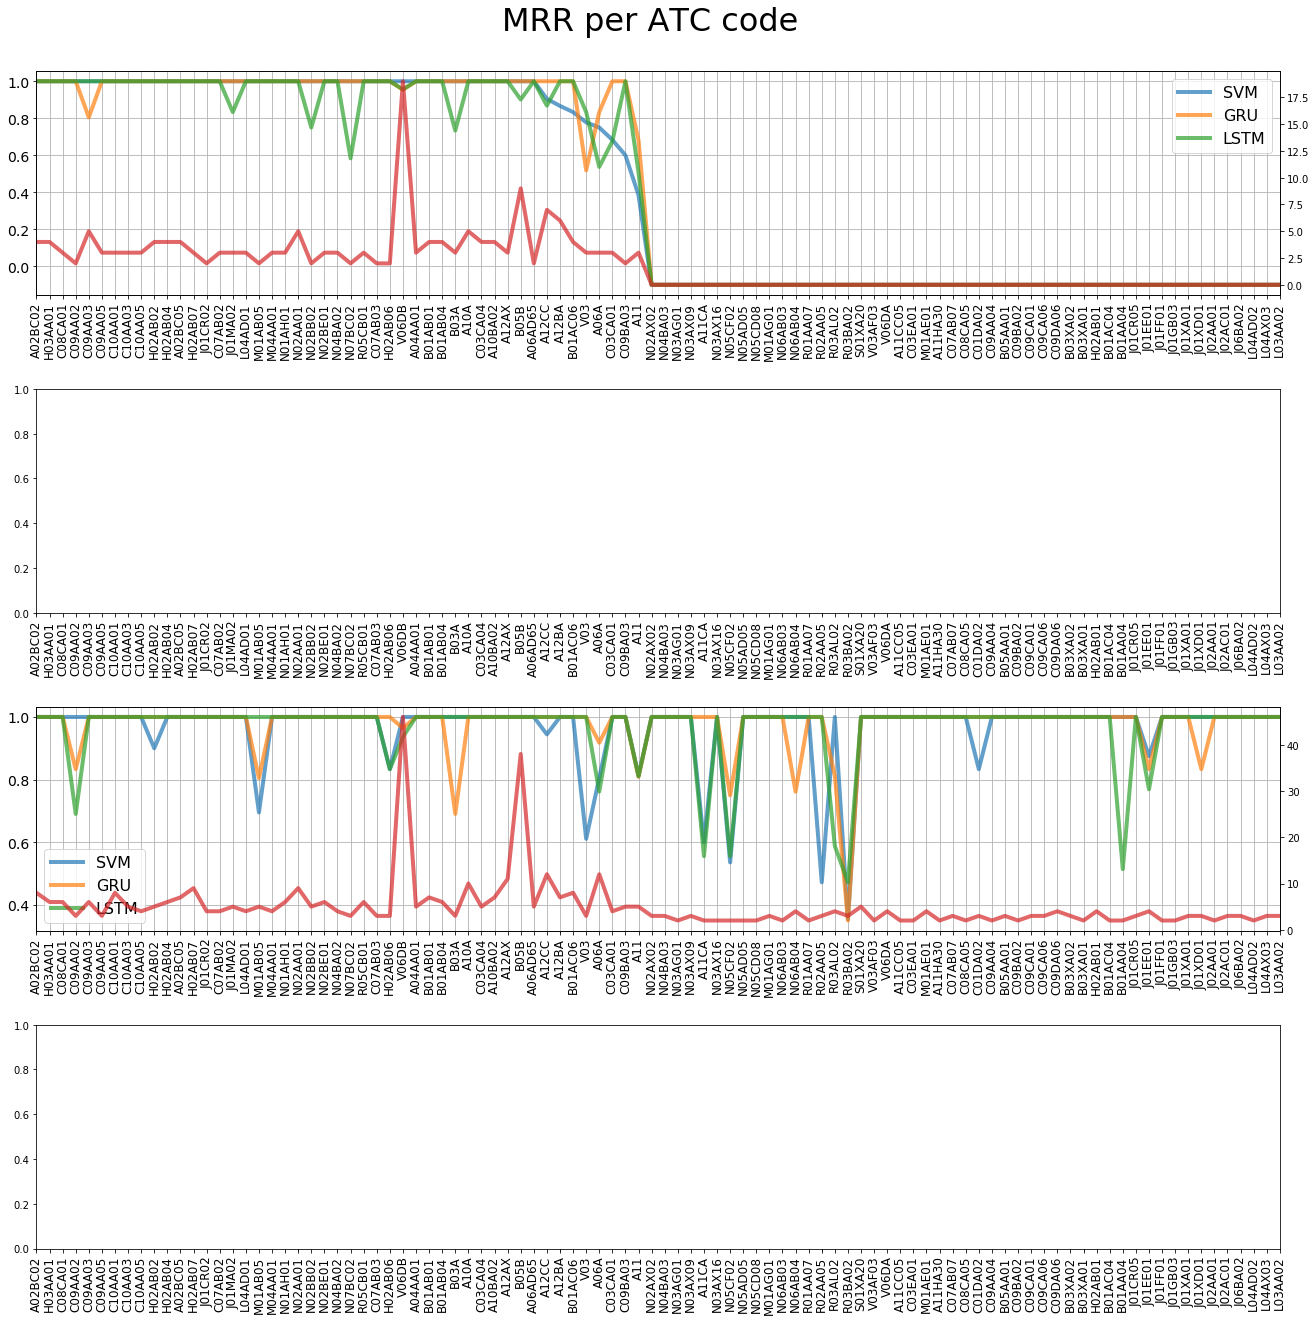

In [340]:
fig, (ax1, ax2, 
      ax3, ax4) = plt.subplots(nrows=4, 
                               ncols=1,
                               figsize=(18, 18), 
                               sharex=True)

axes = (ax1, ax2, ax3, ax4)

fig.tight_layout(h_pad=9)
fig.subplots_adjust(top=0.93)  # adjusting "tightness"

title='MRR per ATC code'
fig.suptitle(title, fontsize=32)

#index mashing, to get index as xticks labels
index_ser = np.arange(len(mrr_per_atc_code))  # arrange indices for x axis
ax1.set_xticks(index_ser)
ax1.set_xticklabels(mrr_per_atc_code.index.values)

alpha = 0.7

# ax1, sim 1.0
mrr_per_atc_code[1.0].plot(ax=ax1, 
                           alpha=alpha,
                           secondary_y='Size of test set',
                           lw=4)

# ax2, sim 0.8

# ax3, sim 0.9
mrr_per_atc_code[0.8].plot(ax=ax3, 
                           alpha=alpha,
                           secondary_y='Size of test set',
                           lw=4)

# ax4, sim 0.7

# for axis in [ax3]:
for axis in (ax1, ax3):
# for axis in axes:
    axis.legend(loc='best', fontsize=legend_font_size)
    axis.grid(True)
    axis.tick_params(axis='y', 
                     which='major', 
                     labelsize=tick_label_font_size)  # axis : {'x', 'y', 'both'}
#     axis.set_xticks(index_ser)
#     axis.set_xticklabels(mrr_per_atc_code.index.values, 
#                          rotation=90, 
#                          size=40)


# # Set top-right text box
# fig.text(0.13, 0.86, 'GRU feedforward\nHidden state dimension = 64\n' +\
#          r'Learning rate = $10^{-1}$', 
#          multialignment='left',
#          backgroundcolor='beige',
#          ha='center', 
#          va='center', 
#          fontsize=16)

# ax1.set_ylabel('Mean Reciprocal Rank', 
#               fontsize=x_axis_label_font_size)

# plt.setp([a.set_xticklabels(mrr_per_atc_code.index.values) 
#           for a in fig.axes[:-1]], visible=True)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True, rotation=90, fontsize=12)


plt.setp(plt.xticks()[1], rotation=90, fontsize=12)

plt.show()
# plt.savefig(figure_dir + 'tensorboard_compare_char_embed_one_hot.pdf', bbox_inches='tight')

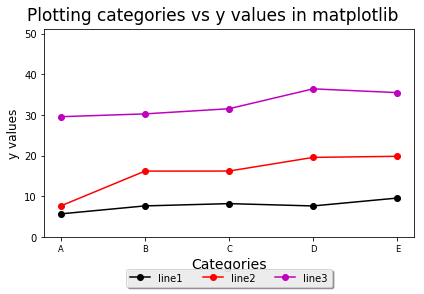

In [189]:
data1=[5.65,7.61,8.17,7.60,9.54]
data2=[7.61,16.17,16.18,19.54,19.81] 
data3=[29.55,30.24,31.51,36.40,35.47]

x_axis=['A','B','C','D','E']

import matplotlib.pyplot as plt
fig=plt.figure() #Creates a new figure
ax1=fig.add_subplot(111) #Plot with: 1 row, 1 column, first subplot.
line1 = ax1.plot(data1,'ko-',label='line1') #no need for str(x_axis)
line2 = ax1.plot(data2,'ro-',label='line2') 
line3 = ax1.plot(data3,'mo-',label='line3') 
plt.xticks(range(len(data3)), x_axis, size='small')
ax1.set_ylim(0,51)
ax1.set_ylabel('y values',fontsize=12)
#Assigning labels
lines = line1+line2+line3
labels = [l.get_label() for l in lines]
ax1.legend(lines,labels,loc='upper center', 
           prop={'size':10}, bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=True, ncol=5)
ax1.set_xlabel('Categories',fontsize=14)
plt.setp(ax1.get_xticklabels(), visible=True)
title_string=('Plotting categories vs y values in matplotlib')
plt.suptitle(title_string, y=1.0, fontsize=17)
fig.tight_layout()
fig.subplots_adjust(top=0.92,bottom=0.2)
plt.show() 